In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Data manipulation
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
from matplotlib import cm

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer


from time import time

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer


# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_hub as hub
from absl import logging


In [2]:
df = pd.read_csv('../data/Capital_Projects.csv')
print(df.shape)
df.tail()

(2259, 16)


,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
2254,09/01/2019 12:00:00 AM,1010,PRIOR NOTICE SIDEWALKS - BROOKLYN,PRIOR NOTICE SIDEWALKS - BROOKLYN,Streets and Roadways,NaN,DDC,DOT,Construction,08/06/2015,29427000.0,NaN,NaN,05/13/2020,NaN,NaN
2255,09/01/2019 12:00:00 AM,1011,"RECONSTRUCTION OF ROSEDALE AREA, PHASE 2",NaN,Streets and Roadways,NaN,DDC,DOT,Design,06/07/2018,39360000.0,NaN,NaN,08/14/2024,NaN,NaN
2256,09/01/2019 12:00:00 AM,1012,"RECONSTRUCTION OF FRONT STREET, MANHATTAN","Reconstruction of Front Street, Manhattan",Streets and Roadways,NaN,DDC,DOT,Construction Procurement,07/31/2015,27356000.0,NaN,NaN,06/16/2022,NaN,NaN
2257,09/01/2019 12:00:00 AM,1013,"GRAND CONCOURSE, PHASE 5",THE FIFTH PHASE OF THE RECONSTRUCTION OF THE G...,Streets and Roadways,NaN,DDC,DOT,Design,09/16/2019,78921000.0,NaN,NaN,09/13/2025,NaN,NaN
2258,09/01/2019 12:00:00 AM,1014,RECONSTRUCTION OF BROADWAY PHASE 2,RECONSTRUCTION OF BROADWAY PHASE 2 - The propo...,Streets and Roadways,NaN,DDC,DOT,Design,08/22/2019,31110000.0,NaN,NaN,07/17/2026,NaN,NaN


In [3]:
df.dtypes

Date Reported As Of         object
PID                          int64
Project Name                object
Description                 object
Category                    object
Borough                     object
Managing Agency             object
Client Agency               object
Current Phase               object
Design Start                object
Budget Forecast            float64
Latest Budget Changes      float64
Total Budget Changes       float64
Forecast Completion         object
Latest Schedule Changes    float64
Total Schedule Changes     float64
dtype: object

## NLP - Text analysis and embedding of the Description column


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/11372120/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df['Description'] = df['Description'].astype(str)
df.dtypes

Date Reported As Of         object
PID                          int64
Project Name                object
Description                 object
Category                    object
Borough                     object
Managing Agency             object
Client Agency               object
Current Phase               object
Design Start                object
Budget Forecast            float64
Latest Budget Changes      float64
Total Budget Changes       float64
Forecast Completion         object
Latest Schedule Changes    float64
Total Schedule Changes     float64
dtype: object

In [6]:
# Define list of stop words and a function to normalize text

stops = set(stopwords.words("english"))
stops = stops.union(['i','say','like','year','one','also','said','use'])

# Define tokenizer to split sentence into tokens
tokenizer = RegexpTokenizer(r'[a-z]+')

def textNormalize(text):
    #print (len(text))
    #textLower = text.astype(str)
    textLower = text.lower()
    textList = tokenizer.tokenize(textLower)
    stopped_doc_tokens = [word for word in textList if not word in stops]
    stopstem_doc_tokens0 = [PorterStemmer().stem(word) for word in stopped_doc_tokens]
    stopstem_doc_tokens = [word for word in stopstem_doc_tokens0 if len(word)>1]
    return stopstem_doc_tokens

#example to check how it works
textNormalize(".. 120 I'm in Delhi India,,, today is 2019. went flying")

['delhi', 'india', 'today', 'went', 'fli']

In [7]:
df['Normalized Description'] = df['Description'].apply(textNormalize)

In [8]:
df['Normalized Description'].head(20)

0     [th, ward, wwtp, mandat, upgrad, preliminari, ...
1     [th, ward, wwtp, mandat, upgrad, preliminari, ...
2     [th, ward, wwtp, mandat, upgrad, preliminari, ...
3     [th, ward, wwtp, mandat, upgrad, preliminari, ...
4     [th, ward, wwtp, mandat, upgrad, preliminari, ...
5     [th, ward, wwtp, mandat, upgrad, preliminari, ...
6     [th, ward, wwtp, mandat, upgrad, preliminari, ...
7     [th, ward, wwtp, mandat, upgrad, preliminari, ...
8     [th, ward, wwtp, mandat, upgrad, preliminari, ...
9     [th, ward, wwtp, mandat, upgrad, preliminari, ...
10    [th, ward, wwtp, mandat, upgrad, preliminari, ...
11    [th, ward, wwtp, mandat, upgrad, preliminari, ...
12    [th, ward, wwtp, mandat, upgrad, preliminari, ...
13    [exist, main, sewag, pump, deterior, pump, sys...
14    [exist, main, sewag, pump, deterior, pump, sys...
15    [exist, main, sewag, pump, deterior, pump, sys...
16    [exist, main, sewag, pump, deterior, pump, sys...
17    [exist, main, sewag, pump, deterior, pump,

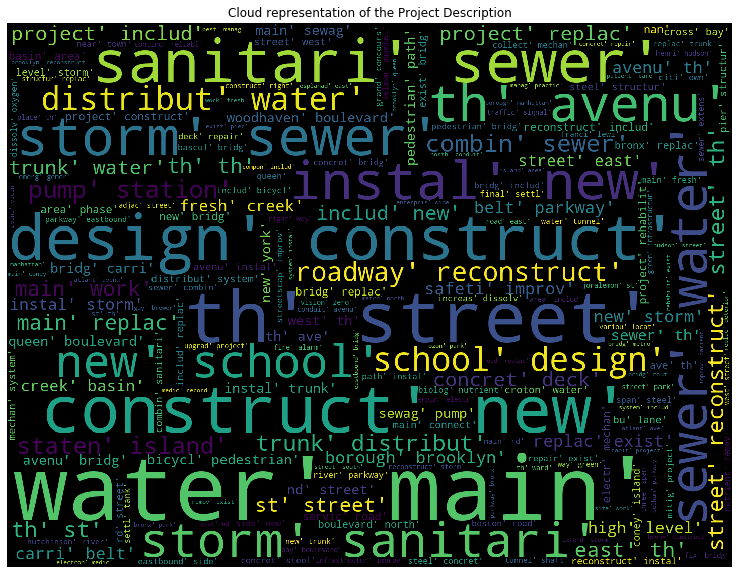

In [9]:
train_qs = pd.Series(df["Normalized Description"].tolist()).astype(str)
qs_text = " ".join(train_qs)

cloud = WordCloud(width=1440, height=1080).generate(qs_text)
plt.figure(figsize=(15, 10))
plt.title("Cloud representation of the Project Description")
plt.imshow(cloud);
plt.axis('off');

In [10]:
df['normal_joined'] = df['Normalized Description'].apply(', '.join)
df['normal_joined'] = df['normal_joined'].apply(lambda x: x.replace(', ', ' '))

In [11]:
df.head(n=3)

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Normalized Description,normal_joined
0,05/01/2014 12:00:00 AM,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Design,09/23/2013,182980960.0,-1915400.0,-4318643.37,01/14/2020,1.0,270.0,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...
1,02/01/2015 12:00:00 AM,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,09/23/2013,168751769.0,-14229191.0,-4318643.37,07/19/2020,187.0,270.0,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...
2,08/01/2015 12:00:00 AM,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction Procurement,09/23/2013,165532447.0,-3219322.0,-4318643.37,08/08/2020,20.0,270.0,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...


In [12]:
text = pd.DataFrame(df['normal_joined'])
text.head()

,normal_joined
0,th ward wwtp mandat upgrad preliminari treatme...
1,th ward wwtp mandat upgrad preliminari treatme...
2,th ward wwtp mandat upgrad preliminari treatme...
3,th ward wwtp mandat upgrad preliminari treatme...
4,th ward wwtp mandat upgrad preliminari treatme...


In [13]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [14]:
test = df.normal_joined
temp = embed(test)


In [15]:
len(temp), len(test), type(temp)

(2259, 2259, tensorflow.python.framework.ops.EagerTensor)

In [16]:
temp2 = list(temp)

In [17]:
len(temp2[0])

512

In [18]:
temp2[0]

<tf.Tensor: id=5664, shape=(512,), dtype=float32, numpy=
array([ 5.17841019e-02, -4.29696916e-03,  5.84666356e-02, -6.85087815e-02,
       -4.37283516e-02,  2.53255777e-02,  3.30587290e-02, -5.39701656e-02,
       -1.14136385e-02,  1.27009619e-02,  6.72228560e-02,  1.43992761e-02,
        2.17853859e-03, -2.46340130e-02,  7.42885396e-02, -6.75984025e-02,
       -2.44629364e-02,  7.55768362e-03, -2.65510138e-02, -5.95454425e-02,
       -2.42839158e-02,  1.57113802e-02, -7.28893653e-02, -6.49019107e-02,
       -7.16357231e-02, -1.44665819e-02, -6.18949160e-03, -5.44435568e-02,
       -1.66089542e-03, -2.46287044e-02, -1.79621745e-02,  8.15290958e-02,
        5.54410294e-02, -2.72466280e-02,  1.58889387e-02,  1.46611063e-02,
        7.83081651e-02,  7.04720849e-03,  1.25579238e-02, -6.97857514e-02,
        1.85230486e-02,  1.14154350e-02,  5.90775385e-02, -5.72614335e-02,
       -2.47751437e-02, -4.22672089e-03,  6.49216073e-03,  3.17749083e-02,
        2.94160127e-04,  4.14689556e-02,  6